# install

### Install Lightning 2.0 

In [1]:
%pip install -qqq lightning
%pip install -qqq timm torchmetrics wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# import

In [2]:
import os
import gc

import time
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision
from torchvision import transforms, datasets

# wandb
import wandb
# from lightning.pytorch.loggers import WandbLogger

# torchmetrics
import torchmetrics

# timm
import timm
from timm import create_model

# import Pytorch Lightning 2.0 
import lightning as L

## Config

In [3]:
config= {'model_name':'resnet18', 
         'seed': 2023,
         'bs': 32,
         'n_epochs': 10,
         'lr': 1e-3,
         'is_compiled': True, 
         'mode': 'default',
        #  'device': "cuda:0", 
         'strategy': "auto",
         }

## Ramdom SEED

In [4]:
L.seed_everything(config['seed'])

INFO: Global seed set to 2023
INFO:lightning.fabric.utilities.seed:Global seed set to 2023


2023

## Data -> Dataset -> DataLoader

In [5]:
def load_data(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    num_workers = os.cpu_count()
    # batch_size = 32

    train_set = datasets.CIFAR10(
        root="~/data", train=True, download=True, transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers= num_workers
    )

    val_set = datasets.CIFAR10(
        root="~/data", train=False, download=True, transform=transform
    )
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=batch_size, shuffle=False, num_workers= num_workers
    )
    print("DataLoader Completed")
    return train_loader, val_loader

In [6]:
train_loader, val_loader = load_data(batch_size = config['bs'])

100%|██████████| 170498071/170498071 [00:05<00:00, 29352991.61it/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data
Files already downloaded and verified
DataLoader Completed


## Device: Fabric

In [7]:
# M1
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Colab
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

device

device(type='cuda', index=0)

## Model

### Define Model

In [8]:
# model = create_model(config["model_name"], pretrained=True,  num_classes=10).to(device)

# get_model after `torch.compile()` or not.

In [9]:
def get_model(model_name = config['model_name'],
              is_compiled = config["is_compiled"],
              mode = None,
              ):
    
    model = create_model(model_name, pretrained=True, num_classes=10)

    if is_compiled:
        print(f"model_name: {model_name} | Compiled?: {is_compiled} | Compiled MODE: {mode}")
        compiled_model = torch.compile(model, mode = mode) #, backend="aot_ts_nvfuser") # backend="inductor")
        return compiled_model

    else:
        
        print(f"model_name: {model_name}")
        return model

In [10]:
model = get_model(model_name = config['model_name'],
                  is_compiled = config["is_compiled"],
                  mode = config["mode"]
                  )


model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


model_name: resnet18 | Compiled?: True | Compiled MODE: default


OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

# Lossfunction, Optimizer

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'])

# train_one_epoch

In [12]:
def train_one_epoch(model, 
                    dataloader, 
                    loss_fn, 
                    optimizer,
                    device, 
                    epoch = 1):
    model.train()
    
    ## initialize metric
    metric_f1 = torchmetrics.F1Score(task='multiclass', average = 'macro', num_classes=10,).to(device)

    train_sum_loss, dataset_size = 0,  0
    preds, trues = [], []
    bar = tqdm(dataloader, total= len(dataloader))
    
    for data in bar:
        x, y_true = data[0].to(device), data[1].to(device)
        bs = x.shape[0]
        y_pred = model(x)           
        
        loss = loss_fn(y_pred, y_true)
        
        # Back-Prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Just for showing loss of "stacked batches" at tqdm progress bar
        dataset_size += bs                   
        train_sum_loss += (loss.item() * bs) 
        train_loss = train_sum_loss / dataset_size 

        # F1: Current Batch
        f1 = metric_f1(y_pred, y_true)
        f1 = f1.detach().cpu().item()
        
        bar.set_description(f"EP:[{epoch+1:02d}]|TL:[{train_loss:.3e}]|F1:[{f1:.2f}]")
                         
    # metric on all batches using custom accumulation
    train_f1 = metric_f1.compute().cpu().item()

    print("Train's F1 Score: %.2f" % (train_f1))
    print()

    # Reseting internal state such that metric ready for new data
    metric_f1.reset()

    torch.cuda.empty_cache()
    _ = gc.collect()

    return train_loss, train_f1


# valid one epoch

In [13]:
@torch.no_grad()
def valid_one_epoch(model, 
                    dataloader, 
                    loss_fn,
                    device, 
                    epoch = 1):
    model.eval()
    
    valid_sum_loss, dataset_size = 0, 0 
    preds, trues = [], []
    bar = tqdm(dataloader, total= len(dataloader))

    ## initialize metric
    metric_f1 = torchmetrics.F1Score(task='multiclass', average = 'macro', num_classes=10).to(device)
    
    with torch.no_grad():
        for data in bar:
            x, y_true = data[0].to(device), data[1].to(device)
            bs = x.shape[0]
            y_pred = model(x) 

            loss = loss_fn(y_pred, y_true)

            # Just for showing loss of "stacked batches" at tqdm progress bar
            dataset_size += bs 
            valid_sum_loss += (loss.item() * bs) 
            valid_loss = valid_sum_loss / dataset_size 

            # F1: Current Batch
            f1 = metric_f1(y_pred, y_true)
            f1 = f1.detach().cpu().item()

            bar.set_description(f"EP:[{epoch + 1 :02d}]|VL:[{valid_loss:.3e}]|F1:[{f1:.2f}]")
    

    # metric on all batches using custom accumulation
    valid_f1 = metric_f1.compute().cpu().item()

    print("Valid's F1 Score: %.2f" % (valid_f1))
    print()

    # Reseting internal state such that metric ready for new data
    metric_f1.reset()

    torch.cuda.empty_cache()
    _ = gc.collect()

    return valid_loss, valid_f1

# Run Train

In [14]:
def run_train(model, 
              train_loader , 
              val_loader, 
              loss_fn, 
              optimizer, 
              device, 
              n_epochs,
              print_iter= 10,
              early_stop = 20
              ):
    
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    start = time.time()
    
    train_hs, valid_hs, train_f1s, valid_f1s = [], [], [], []
    
    lowest_loss, lowest_epoch = np.inf, np.inf
    
    for epoch in range(n_epochs):
        
        train_loss, train_f1 = train_one_epoch(model = model,
                                                dataloader = train_loader, 
                                                loss_fn = loss_fn,
                                                optimizer = optimizer,
                                                device = device, 
                                                epoch = epoch)
        
        valid_loss, valid_f1 = valid_one_epoch(model = model, 
                                                dataloader = val_loader, 
                                                loss_fn = loss_fn,
                                                device = device, 
                                                epoch = epoch)
        print()
        train_hs.append(train_loss)
        train_f1s.append(train_f1)
        valid_hs.append(valid_loss)
        valid_f1s.append(valid_f1)

        # Log the metrics
        wandb.log({"train_loss_epoch": train_loss})
        wandb.log({"valid_loss_epoch": valid_loss})

        # # Log the metrics
        wandb.log({"train_f1_epoch": train_f1})
        wandb.log({"valid_f1_epoch": valid_f1})

        if (epoch + 1) % print_iter == 0:
            print()
            print(f"Ep:[{epoch+1}]|TL:{train_loss:.3e}|VL:{valid_loss:.3e}|LL:{lowest_loss:.3e}")
            print()

        # 'Lowest Loss' update by 'valid loss' 
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = epoch
            torch.save(model.state_dict(), './model.bin')
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch +1:
                print("There is no improvement during last %d epochs" % early_stop)
                break
                
    print()
    print("The Best Validation Loss= %.3e at %d Epoch" % (lowest_loss, lowest_epoch))
    
    # model load
    model.load_state_dict(torch.load('./model.bin'))
    
    # result
    result = dict()
    result["Train Loss"] = train_hs
    result["Valid Loss"] = valid_hs

    result["Train F1 Score"] = train_f1s
    result["Valid F1 Score"] = valid_f1s
        
    print()
    end = time.time()
    time_elapsed = end - start

    print('Training and Validation complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))

    return model, result
            

## wandb init()

In [15]:
################### wandb ######################
run = wandb.init(project='fabric_test', 
                 config=config,
                 job_type='Train',
                 name = "[compiled] only_torch",
                 anonymous='must'
                 )

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Let's Train!

In [16]:
model, result = run_train(model = model, 
                          train_loader = train_loader, 
                          val_loader = val_loader, 
                          loss_fn = loss_fn, 
                          optimizer = optimizer, 
                          device = device, 
                          n_epochs = config['n_epochs'], 
                          print_iter= 10,
                          early_stop = 20
                          )

EP:[01]|TL:[1.093e+00]|F1:[0.60]: 100%|██████████| 1563/1563 [03:08<00:00,  8.28it/s]


Train's F1 Score: 0.63



EP:[01]|VL:[8.030e-01]|F1:[0.36]: 100%|██████████| 313/313 [00:22<00:00, 14.21it/s]


Valid's F1 Score: 0.73




EP:[02]|TL:[7.653e-01]|F1:[0.68]: 100%|██████████| 1563/1563 [00:53<00:00, 29.18it/s]


Train's F1 Score: 0.74



EP:[02]|VL:[6.697e-01]|F1:[0.48]: 100%|██████████| 313/313 [00:06<00:00, 51.67it/s]


Valid's F1 Score: 0.77




EP:[03]|TL:[6.223e-01]|F1:[0.61]: 100%|██████████| 1563/1563 [00:53<00:00, 29.49it/s]


Train's F1 Score: 0.79



EP:[03]|VL:[6.572e-01]|F1:[0.36]: 100%|██████████| 313/313 [00:05<00:00, 58.01it/s]


Valid's F1 Score: 0.78




EP:[04]|TL:[5.042e-01]|F1:[0.80]: 100%|██████████| 1563/1563 [00:53<00:00, 29.12it/s]


Train's F1 Score: 0.83



EP:[04]|VL:[6.902e-01]|F1:[0.36]: 100%|██████████| 313/313 [00:06<00:00, 51.13it/s]


Valid's F1 Score: 0.77




EP:[05]|TL:[4.155e-01]|F1:[0.68]: 100%|██████████| 1563/1563 [00:52<00:00, 29.81it/s]


Train's F1 Score: 0.86



EP:[05]|VL:[6.372e-01]|F1:[0.40]: 100%|██████████| 313/313 [00:07<00:00, 40.12it/s]


Valid's F1 Score: 0.80




EP:[06]|TL:[3.363e-01]|F1:[0.56]: 100%|██████████| 1563/1563 [00:52<00:00, 29.94it/s]


Train's F1 Score: 0.89



EP:[06]|VL:[7.284e-01]|F1:[0.36]: 100%|██████████| 313/313 [00:05<00:00, 53.95it/s]


Valid's F1 Score: 0.77




EP:[07]|TL:[2.696e-01]|F1:[0.56]: 100%|██████████| 1563/1563 [00:51<00:00, 30.21it/s]


Train's F1 Score: 0.91



EP:[07]|VL:[6.739e-01]|F1:[0.45]: 100%|██████████| 313/313 [00:05<00:00, 58.69it/s]


Valid's F1 Score: 0.80




EP:[08]|TL:[2.057e-01]|F1:[0.48]: 100%|██████████| 1563/1563 [00:54<00:00, 28.82it/s]


Train's F1 Score: 0.93



EP:[08]|VL:[7.122e-01]|F1:[0.44]: 100%|██████████| 313/313 [00:06<00:00, 46.81it/s]


Valid's F1 Score: 0.79




EP:[09]|TL:[2.071e-01]|F1:[0.57]: 100%|██████████| 1563/1563 [00:52<00:00, 29.88it/s]


Train's F1 Score: 0.93



EP:[09]|VL:[7.138e-01]|F1:[0.46]: 100%|██████████| 313/313 [00:06<00:00, 47.36it/s]


Valid's F1 Score: 0.80




EP:[10]|TL:[1.459e-01]|F1:[0.79]: 100%|██████████| 1563/1563 [00:53<00:00, 29.18it/s]


Train's F1 Score: 0.95



EP:[10]|VL:[7.284e-01]|F1:[0.57]: 100%|██████████| 313/313 [00:05<00:00, 59.55it/s]


Valid's F1 Score: 0.81



Ep:[10]|TL:1.459e-01|VL:7.284e-01|LL:6.372e-01


The Best Validation Loss= 6.372e-01 at 4 Epoch

Training and Validation complete in 0h 12m 29s


# Visualization

In [17]:
################## Visualize #########################   
def make_plot(result, stage = "Loss"):

    plot_from = 0

    trains = f"Train {stage}"
    valids = f"Valid {stage}"

    plt.figure(figsize=(10, 6))
    
    plt.title(f"Train/Valid {stage} History", fontsize = 20)

    ## Modified for converting Type
    if type(result[trains][0]) == torch.Tensor:
        result[trains] = [num.detach().cpu().item() for num in result[trains]]
        result[valids] = [num.detach().cpu().item() for num in result[valids]]

    plt.plot(
        range(0, len(result[trains][plot_from:])), 
        result[trains][plot_from:], 
        label = trains
        )

    plt.plot(
        range(0, len(result[valids][plot_from:])), 
        result[valids][plot_from:], 
        label = valids
        )

    plt.legend()
    if stage == "loss":
        plt.yscale('log')
    plt.grid(True)
    plt.show()
    
    

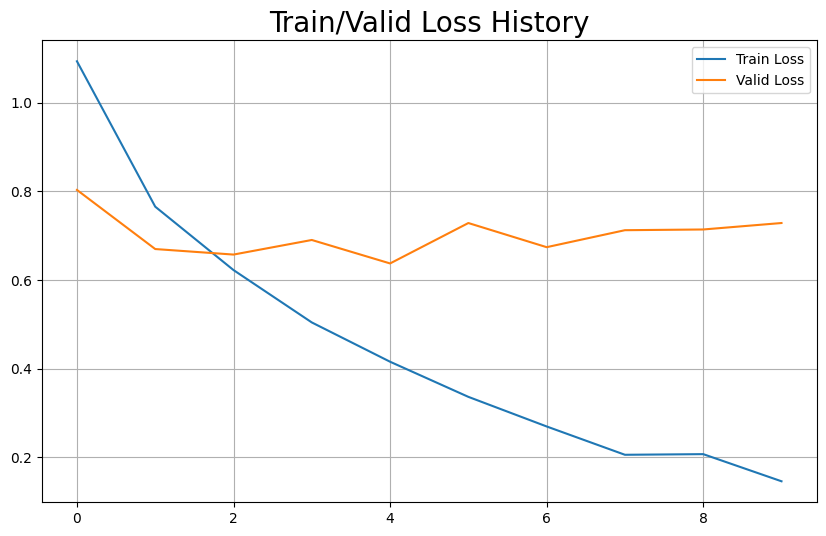

In [18]:
make_plot(result, stage = "Loss")

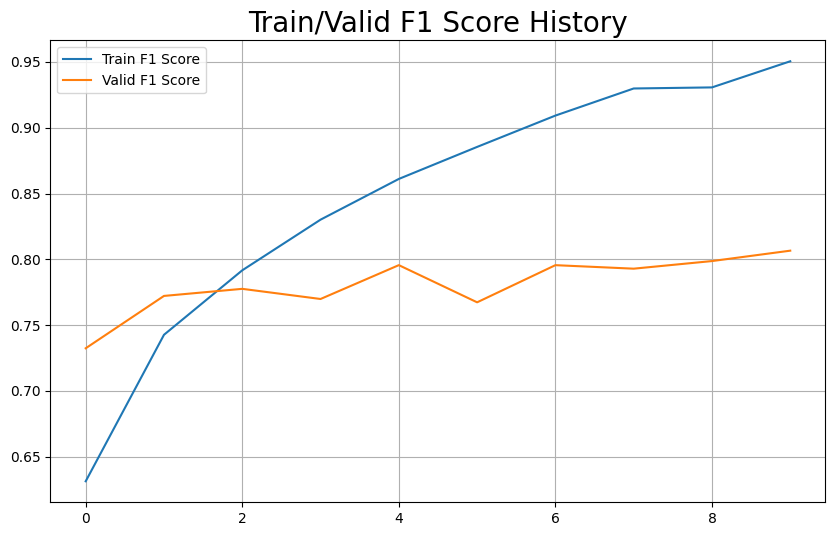

In [19]:
make_plot(result, stage = "F1 Score")

## wandb finish

In [20]:
############ wandb.finish() #################
run.finish()

train_f1_epoch,▁▃▅▅▆▇▇███
train_loss_epoch,█▆▅▄▃▂▂▁▁▁
valid_f1_epoch,▁▅▅▅▇▄▇▇▇█
valid_loss_epoch,█▂▂▃▁▅▃▄▄▅
train_f1_epoch,0.95047
train_loss_epoch,0.1459
valid_f1_epoch,0.80655
valid_loss_epoch,0.72841
